In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
import h5py
from pykeops.torch import LazyTensor, generic_sum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from scipy.special import gamma, kv
from scipy.stats import mode

import sys
sys.path.append("../..")
from losses import squared_error, relative_error
from rkhs_functions import make_kernel, RKHSFunction
from training_functions import train_rkhs_pde
from helper import trapezoid_rule, standard_deviation
from constraints import FlipSymmetric

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [ ]:
###############################################################################
#   Generate Fokker-Planck Equation Forcings and Solutions
###############################################################################

m = 50
kernel_width = 0.1

data = h5py.File("../../generate_data/fplanck_gaussianKLE.hdf5", "r")
x_train, t_train = data[f"mesh{m}"].attrs["mesh"]
mx_train = len(x_train)
mt_train = len(t_train)

num_train = 500
fs_train = data[f"mesh{m}"][f"kernelwidth{kernel_width}"]["forcings"][:num_train, :]
us_train_clean = data[f"mesh{m}"][f"kernelwidth{kernel_width}"]["solutions"][:num_train, :]

x_train = torch.from_numpy(x_train).type(tensor)
t_train = torch.from_numpy(t_train).type(tensor)
fs_train = torch.from_numpy(fs_train).type(tensor)
us_train_clean = torch.from_numpy(us_train_clean).type(tensor)

# add noise to solutions at a given SNR
sigma = 0.2
us_train = us_train_clean + sigma * standard_deviation(us_train_clean) * torch.randn(num_train, mx_train*mt_train).type(tensor)

mx_true = 100
mt_true = 100
x_true = torch.linspace(-2, 2, mx_true).type(tensor)
t_true = torch.linspace(0, 1, mt_true).type(tensor)

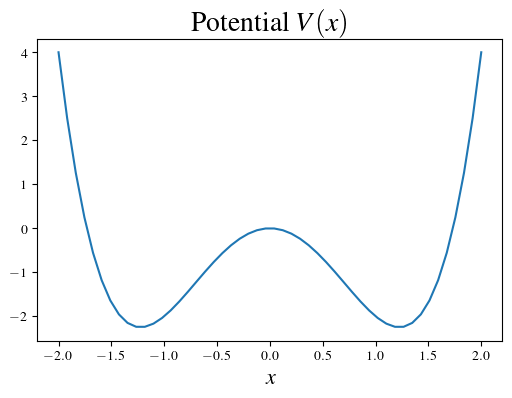

In [3]:
U = lambda x: np.power(x, 4) - 3*np.power(x, 2)

plt.figure(dpi=100)
plt.plot(x_train.cpu(), U(x_train.cpu().numpy()))
plt.xlabel("$x$", fontsize=16)
plt.title("Potential $V(x)$", fontsize=20)
plt.savefig("../../figures/fplanck_potential.png")
plt.show()

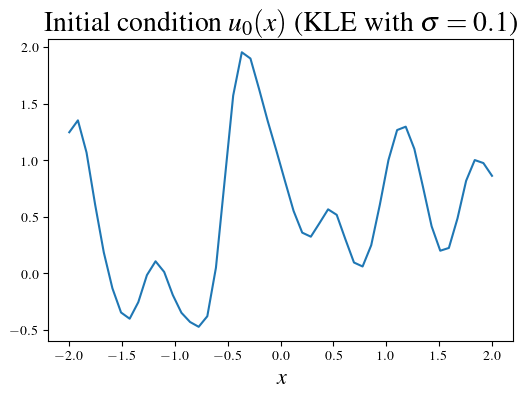

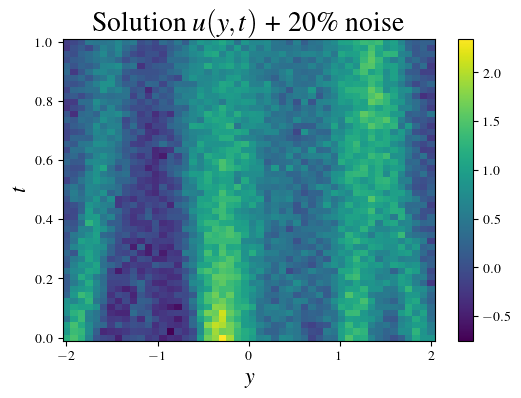

In [4]:
i = 50

plt.figure(dpi=100)
plt.plot(x_train.cpu(), fs_train[i, :].cpu())
plt.xlabel("$x$", fontsize=16)
plt.title("Initial condition $u_0(x)$ (KLE with $\sigma = 0.1$)", fontsize=20)
plt.savefig("../../figures/fplanck_initialcond.png")
plt.show()

plt.figure(dpi=100)
plt.pcolormesh(x_train.cpu(), t_train.cpu(), us_train[i, :].view(mx_train, mt_train).cpu().T)
plt.xlabel("$y$", fontsize=16)
plt.ylabel("$t$", fontsize=16)
plt.title("Solution $u(y, t)$ + $20\%$ noise", fontsize=20)
plt.colorbar()
plt.savefig("../../figures/fplanck_solution.png")
plt.show()

### Solve Fokker-Planck with Space-Symmetric Kernel

In [4]:
mx_weight = mx_train
mt_weight = mt_train
x_weight = torch.linspace(x_train.min(), x_train.max(), mx_weight).type(tensor)
t_weight = torch.linspace(t_train.min(), t_train.max(), mt_weight).type(tensor)

kernel = "Matern3/2"
rkhs_kernel_width = torch.tensor([8/mx_weight, 8/mx_weight, 2/mx_weight]).type(tensor)

lmbda = 1e-5

epochs = 100
plotting_freq = 10
batch_size = 100
learning_rate = None

ind_divisor = 0
greens_out_meshes = (x_train, x_train, t_train)
greens_out_meshes_true = (x_true, x_true, t_true)
greens_weight_meshes = (x_weight, x_weight, t_weight)
greens_quadrature = trapezoid_rule(greens_weight_meshes).flatten()

greens_weight_parametrizations = [FlipSymmetric((mx_weight, mx_weight, mt_weight), [0, 1])]

def greens_transform_output(G, meshes):
    sizes = [len(x) for x in meshes]
    G = greens_weight_parametrizations[0](G, dims=sizes)
    return G

def plotting_function(us_train_hat):
    example_ind = 0
    u = us_train[example_ind, :].cpu().view(mx_train, mt_train)
    u_hat = us_train_hat[example_ind, :].cpu().view(mx_train, mt_train)
    plt.figure(1)
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Training Output Example', fontweight='bold')
    im = axs[0].pcolormesh(x_train.cpu(), t_train.cpu(), u.T)
    axs[0].set_title("$u$")
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('t')
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im = axs[1].pcolormesh(x_train.cpu(), t_train.cpu(), u_hat.detach().T)
    axs[1].set_title("$\widehat{u}$")
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('t')
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout()
    plt.show()

In [5]:
f_size = math.prod([len(x) for x in greens_out_meshes[:ind_divisor+1]])
f_size_true = math.prod([len(x) for x in greens_out_meshes_true[:ind_divisor+1]])
f_quadrature = trapezoid_rule(greens_out_meshes[:ind_divisor+1]).flatten()
u_size = math.prod([len(x) for x in greens_out_meshes[ind_divisor+1:]])
u_size_true = math.prod([len(x) for x in greens_out_meshes_true[ind_divisor+1:]])
u_quadrature = trapezoid_rule(greens_out_meshes[ind_divisor+1:]).flatten()

Green's Function Learning Rate: 100
Epoch 1 Relative Error 1533.7750244140625
First epoch had re = 1533.7750244140625 > 1
Green's Function Learning Rate: 50
Epoch 1 Relative Error 1080.373291015625
First epoch had re = 1080.373291015625 > 1
Green's Function Learning Rate: 10
Epoch 1 Relative Error 173.61215209960938
First epoch had re = 173.61215209960938 > 1
Green's Function Learning Rate: 5
Epoch 1 Relative Error 88.07063293457031
First epoch had re = 88.07063293457031 > 1
Green's Function Learning Rate: 1
Epoch 1 Relative Error 15.487560272216797
First epoch had re = 15.487560272216797 > 1
Green's Function Learning Rate: 0.5
Epoch 1 Relative Error 8.784191131591797
First epoch had re = 8.784191131591797 > 1
Green's Function Learning Rate: 0.1
Epoch 1 Relative Error 1.1482770442962646
First epoch had re = 1.1482770442962646 > 1
Green's Function Learning Rate: 0.05
Epoch 1 Relative Error 0.9610284566879272
Epoch 2 Relative Error 0.5966588854789734
Epoch 3 Relative Error 0.485466212034

<Figure size 432x288 with 0 Axes>

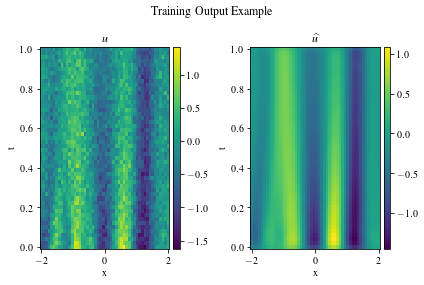

Epoch 10 Relative Error 0.2784852981567383
Epoch 11 Relative Error 0.2686517834663391
Epoch 12 Relative Error 0.2643318176269531
Epoch 13 Relative Error 0.2616385817527771
Epoch 14 Relative Error 0.25951850414276123
Epoch 15 Relative Error 0.25719550251960754
Epoch 16 Relative Error 0.25543683767318726
Epoch 17 Relative Error 0.25405681133270264
Epoch 18 Relative Error 0.25296542048454285
Epoch 19 Relative Error 0.2519744336605072


<Figure size 432x288 with 0 Axes>

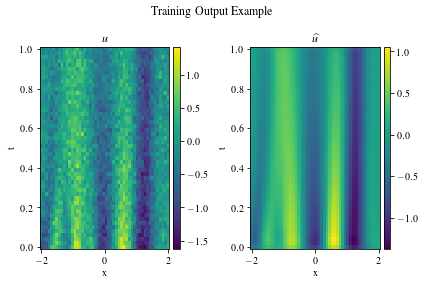

Epoch 20 Relative Error 0.25103017687797546
Epoch 21 Relative Error 0.2502899467945099
Epoch 22 Relative Error 0.24958276748657227
Epoch 23 Relative Error 0.24883703887462616
Epoch 24 Relative Error 0.24827095866203308
Epoch 25 Relative Error 0.24767369031906128
Epoch 26 Relative Error 0.2471047341823578
Epoch 27 Relative Error 0.2466205507516861
Epoch 28 Relative Error 0.2462480515241623
Epoch 29 Relative Error 0.24583503603935242


<Figure size 432x288 with 0 Axes>

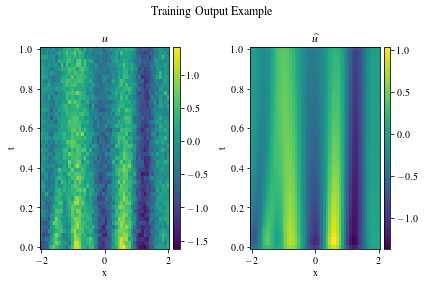

Epoch 30 Relative Error 0.2454262673854828
Epoch 31 Relative Error 0.2449961155653
Epoch 32 Relative Error 0.24463465809822083
Epoch 33 Relative Error 0.2442360520362854
Epoch 34 Relative Error 0.24400551617145538
Epoch 35 Relative Error 0.24359126389026642
Epoch 36 Relative Error 0.24335607886314392
Epoch 37 Relative Error 0.24300386011600494
Epoch 38 Relative Error 0.24270068109035492
Epoch 39 Relative Error 0.24251176416873932


<Figure size 432x288 with 0 Axes>

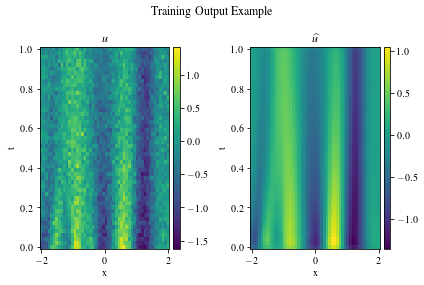

Epoch 40 Relative Error 0.2422151416540146
Epoch 41 Relative Error 0.24199171364307404
Epoch 42 Relative Error 0.24177204072475433
Epoch 43 Relative Error 0.24157001078128815
Epoch 44 Relative Error 0.24134473502635956
Epoch 45 Relative Error 0.24116529524326324
Epoch 46 Relative Error 0.24096816778182983
Epoch 47 Relative Error 0.24076710641384125
Epoch 48 Relative Error 0.24063675105571747
Epoch 49 Relative Error 0.2404099404811859


<Figure size 432x288 with 0 Axes>

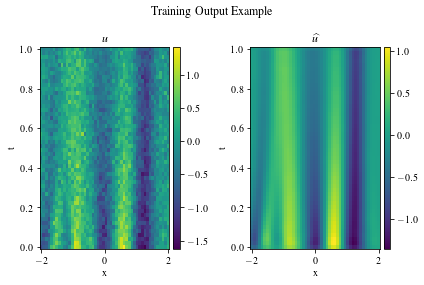

Epoch 50 Relative Error 0.2402866929769516
Epoch 51 Relative Error 0.24021080136299133
Epoch 52 Relative Error 0.24001052975654602
Epoch 53 Relative Error 0.23985810577869415
Epoch 54 Relative Error 0.23972532153129578
Epoch 55 Relative Error 0.23960380256175995
Epoch 56 Relative Error 0.23944418132305145
Epoch 57 Relative Error 0.2393650859594345
Epoch 58 Relative Error 0.23916634917259216
Epoch 59 Relative Error 0.23913805186748505


<Figure size 432x288 with 0 Axes>

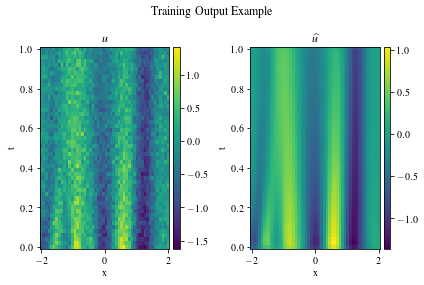

Epoch 60 Relative Error 0.23895598948001862
Epoch 61 Relative Error 0.23885320127010345
Epoch 62 Relative Error 0.2386731654405594
Epoch 63 Relative Error 0.2385331094264984
Epoch 64 Relative Error 0.23843716084957123
Epoch 65 Relative Error 0.23835141956806183
Epoch 66 Relative Error 0.23822662234306335
Epoch 67 Relative Error 0.2381175458431244
Epoch 68 Relative Error 0.23817859590053558
Epoch 69 Relative Error 0.23795954883098602


<Figure size 432x288 with 0 Axes>

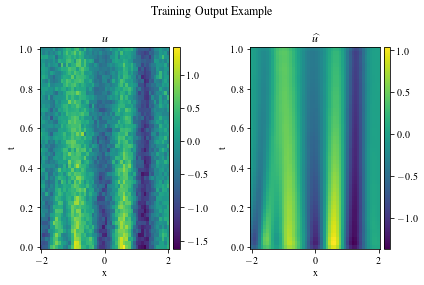

Epoch 70 Relative Error 0.23793141543865204
Epoch 71 Relative Error 0.23776887357234955
Epoch 72 Relative Error 0.23771069943904877
Epoch 73 Relative Error 0.23761910200119019
Epoch 74 Relative Error 0.237698495388031
Epoch 75 Relative Error 0.23754669725894928
Epoch 76 Relative Error 0.2375212162733078
Epoch 77 Relative Error 0.2374344915151596
Epoch 78 Relative Error 0.2373294234275818
Epoch 79 Relative Error 0.23723722994327545


<Figure size 432x288 with 0 Axes>

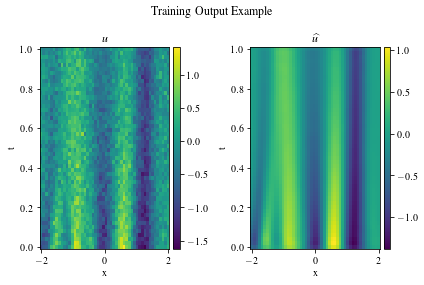

Epoch 80 Relative Error 0.23711256682872772
Epoch 81 Relative Error 0.23696079850196838
Epoch 82 Relative Error 0.237021341919899
Epoch 83 Relative Error 0.23682309687137604
Epoch 84 Relative Error 0.23679035902023315
Epoch 85 Relative Error 0.23680680990219116
Epoch 86 Relative Error 0.23679442703723907
Epoch 87 Relative Error 0.23678933084011078
Epoch 88 Relative Error 0.23659910261631012
Epoch 89 Relative Error 0.23672646284103394


<Figure size 432x288 with 0 Axes>

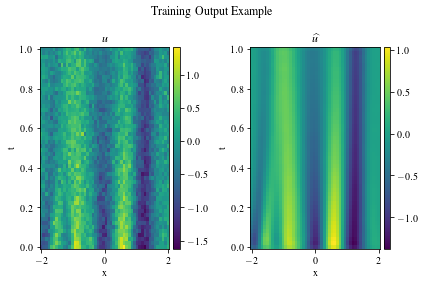

Epoch 90 Relative Error 0.23650509119033813
Epoch 91 Relative Error 0.23651526868343353
Epoch 92 Relative Error 0.2364737093448639
Epoch 93 Relative Error 0.23642709851264954
Epoch 94 Relative Error 0.2362775057554245
Epoch 95 Relative Error 0.23632872104644775
Epoch 96 Relative Error 0.23613634705543518
Epoch 97 Relative Error 0.23613634705543518
Epoch 98 Relative Error 0.23610760271549225
Epoch 99 Relative Error 0.23620836436748505


<Figure size 432x288 with 0 Axes>

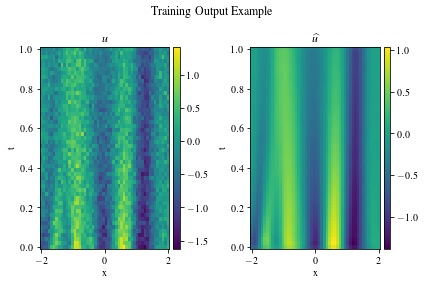

Epoch 100 Relative Error 0.23595234751701355


In [12]:
# Fit smooth Green's function in RKHS to heat equation
greens_function, _, _, _, res, _, _, G_norms, _ = \
    train_rkhs_pde(fs_train, us_train, ind_divisor, kernel, rkhs_kernel_width,
                   greens_out_meshes, greens_weight_meshes,
                   greens_lmbda=lmbda,
                   batch_size=batch_size, epochs=epochs,
                   greens_learning_rate=None,
                   greens_weight_parametrizations=greens_weight_parametrizations,
                   greens_transform_output=greens_transform_output,
                   plotting_function=plotting_function, plotting_freq=plotting_freq, verbal=True)

torch.save(greens_function.state_dict(), "fplanck_greens_function.pkl")

In [6]:
greens_weight = torch.load("fplanck_greens_function.pkl")['parametrizations.weight.original']
greens_function = RKHSFunction(greens_out_meshes_true, greens_weight_meshes,
                                   kernel=kernel, sigma=rkhs_kernel_width, dtype=torch.cuda.FloatTensor)
greens_function.weight = torch.nn.Parameter(greens_weight)

/home/gridsan/gstepaniants/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


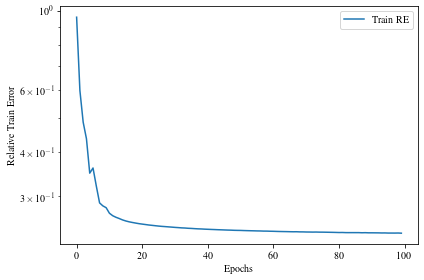

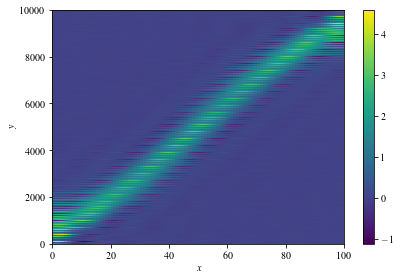

Train Relative Error: 0.23595234751701355


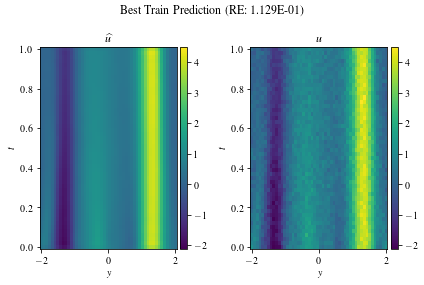

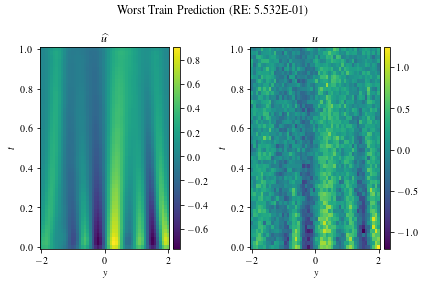

In [13]:
# get re for all examples in train set
greens_function.update_mesh(greens_out_meshes)
G = greens_function()
G = torch.reshape(G, (f_size, u_size))
us_train_hat = (fs_train * f_quadrature) @ G
train_res = relative_error(us_train_hat.cpu(), us_train.cpu())

# interpolate Green's function and bias term to fine mesh
greens_function.update_mesh(greens_out_meshes_true)
G = greens_function()
G = torch.reshape(G, (f_size_true, u_size_true))

# plot relative errors over iterations
plt.figure(2)
#plt.title('Train Relative Errors', fontweight='bold')
plt.plot(range(len(res)), res, label='Train RE', zorder=2)
plt.xlabel('Epochs')
plt.ylabel('Relative Train Error')
plt.yscale('log')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('train_errors', dpi=300)
plt.show()

# plot learned Green's function
plt.figure(3)
#plt.title('Predicted Green\'s Kernel $\widehat{G}(x, y)$' + ' (RE: {:.3E})'.format(G_res[-1]), fontweight='bold')
plt.pcolormesh(G.cpu().detach().T, shading='auto')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()
plt.savefig('pred_green', dpi=300)
plt.show()

# compute the relative train error on the solutions
train_re = res[-1]
print('Train Relative Error: ' + str(train_re))

# plot best and worst case train predictions
best_re, best_ind = torch.min(train_res, 0)
worst_re, worst_ind = torch.max(train_res, 0)


fig, axs = plt.subplots(1, 2)
fig.suptitle('Best Train Prediction (RE: {:.3E})'.format(best_re), fontweight='bold')
u = us_train[best_ind, :].cpu().detach().view(mx_train, mt_train)
u_hat = us_train_hat[best_ind, :].cpu().detach().view(mx_train, mt_train)
vmin = torch.minimum(torch.min(u), torch.min(u_hat))
vmax = torch.maximum(torch.max(u), torch.max(u_hat))

im = axs[0].pcolormesh(x_train.cpu(), t_train.cpu(), u_hat.T, vmin=vmin, vmax=vmax)
axs[0].set_title("$\widehat{u}$")
axs[0].set_xlabel('$y$')
axs[0].set_ylabel('$t$')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1].pcolormesh(x_train.cpu(), t_train.cpu(), u.T, vmin=vmin, vmax=vmax)
axs[1].set_title("$u$")
axs[1].set_xlabel('$y$')
axs[1].set_ylabel('$t$')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2)
fig.suptitle('Worst Train Prediction (RE: {:.3E})'.format(worst_re), fontweight='bold')
u = us_train[worst_ind, :].cpu().detach().view(mx_train, mt_train)
u_hat = us_train_hat[worst_ind, :].cpu().detach().view(mx_train, mt_train)

im = axs[0].pcolormesh(x_train.cpu(), t_train.cpu(), u_hat.T)
axs[0].set_title("$\widehat{u}$")
axs[0].set_xlabel('$y$')
axs[0].set_ylabel('$t$')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1].pcolormesh(x_train.cpu(), t_train.cpu(), u.T)
axs[1].set_title("$u$")
axs[1].set_xlabel('$y$')
axs[1].set_ylabel('$t$')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()
plt.show()

[KeOps] Generating code for formula Sum_Reduction(((1+Var(2,1,2)*Sqrt(Sum((Var(0,3,0)-Var(1,3,1))**2)))*Exp(Var(3,1,2)*Sqrt(Sum((Var(0,3,0)-Var(1,3,1))**2))))*Var(4,1,1),0) ... OK


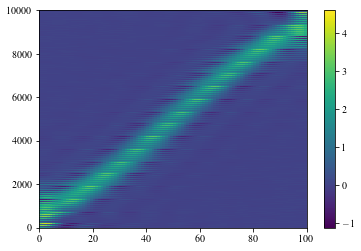

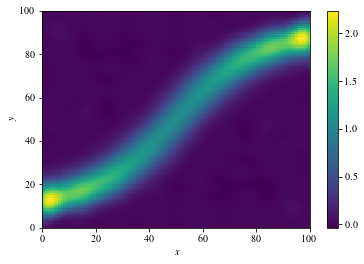

In [7]:
greens_function.update_mesh(greens_out_meshes_true)
G = greens_function()
G = torch.reshape(G, (f_size_true, u_size_true))

plt.pcolormesh(G.cpu().detach().T)
plt.colorbar()
plt.show()

plt.pcolormesh(G.cpu().detach().view(mx_true, mx_true, mt_true)[:, :, 99].T)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()
plt.show()


In [8]:
###############################################################################
#   Test Functional Neural Network on New Mesh Sizes
###############################################################################

# number of test samples
num_test = 500

kernel_width_sizes = [1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1, 2.5e-1, 5e-1, 7.5e-1, 1.0, 2.5, 5.0, 7.5, 10.0]
mesh_sizes = [50, 100, 200, 300]

test_sigma = 0.0

test_mesh_res = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
best_f = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
best_u = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
best_u_hat = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
best_res = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
best_inds = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
worst_f = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
worst_u = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
worst_u_hat = np.empty((len(mesh_sizes), len(kernel_width_sizes)), dtype="object")
worst_res = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
worst_inds = np.zeros((len(mesh_sizes), len(kernel_width_sizes)))
for i in range(len(mesh_sizes)):
    for j in range(len(kernel_width_sizes)):
        print(f'({i}, {j})')
        m = mesh_sizes[i]
        w = kernel_width_sizes[j]
        
        x_test, t_test = data[f"mesh{m}"].attrs["mesh"]
        mx_test = len(x_test)
        mt_test = len(t_test)

        fs_test = data[f"mesh{m}"][f"kernelwidth{w}"]["forcings"][-num_test:, :]
        us_test_clean = data[f"mesh{m}"][f"kernelwidth{w}"]["solutions"][-num_test:, :]

        x_test = torch.from_numpy(x_test).type(tensor)
        t_test = torch.from_numpy(t_test).type(tensor)
        fs_test = torch.from_numpy(fs_test).type(tensor)
        us_test_clean = torch.from_numpy(us_test_clean).type(tensor)
        
        # add noise to solutions at a given SNR
        us_test = us_test_clean + test_sigma * standard_deviation(us_test_clean) * torch.randn(num_test, mx_test*mt_test).type(tensor)
        
        greens_out_meshes_test = (x_test, x_test, t_test)
        f_size_test = mx_test
        f_quadrature_test = trapezoid_rule((x_test,)).flatten()
        u_size_test = mx_test*mt_test
        
        greens_function.update_mesh(greens_out_meshes_test)
        G = greens_function()
        G = torch.reshape(G, (f_size_test, u_size_test))
        
        us_test_hat = (fs_test * f_quadrature_test) @ G
        test_res = relative_error(us_test_hat, us_test)
        test_mesh_res[i, j] = torch.mean(test_res).item()
        
        best_res[i, j], best_ind = torch.min(test_res, 0)
        best_f[i, j] = fs_test[best_ind, :].cpu().detach()
        best_u[i, j] = us_test[best_ind, :].cpu().detach().view(m, m)
        best_u_hat[i, j] = us_test_hat[best_ind, :].cpu().detach().view(m, m)
        best_inds[i, j] = best_ind
        
        worst_res[i, j], worst_ind = torch.max(test_res, 0)
        worst_f[i, j] = fs_test[worst_ind, :].cpu().detach()
        worst_u[i, j] = us_test[worst_ind, :].cpu().detach().view(m, m)
        worst_u_hat[i, j] = us_test_hat[worst_ind, :].cpu().detach().view(m, m)
        worst_inds[i, j] = worst_ind

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)


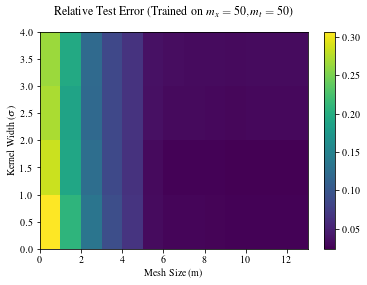

In [17]:
# plot test error of model on new test meshes
plt.figure(7)
plt.title(f'Relative Test Error (Trained on $m_x = {mx_train}, m_t = {mt_train}$)', y=1.05, fontweight='bold')
plt.pcolormesh(test_mesh_res)
plt.xlabel('Mesh Size (m)')
plt.ylabel('Kernel Width ($\sigma$)')
plt.colorbar()
plt.show()

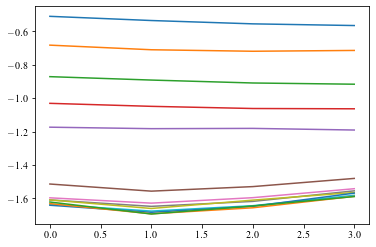

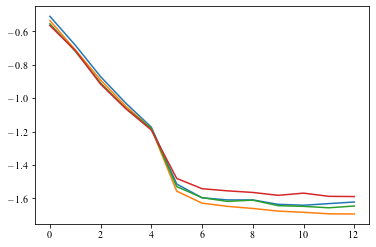

In [17]:
plt.plot(np.log10(test_mesh_res))
plt.show()

plt.plot(np.log10(test_mesh_res).T)
plt.show()

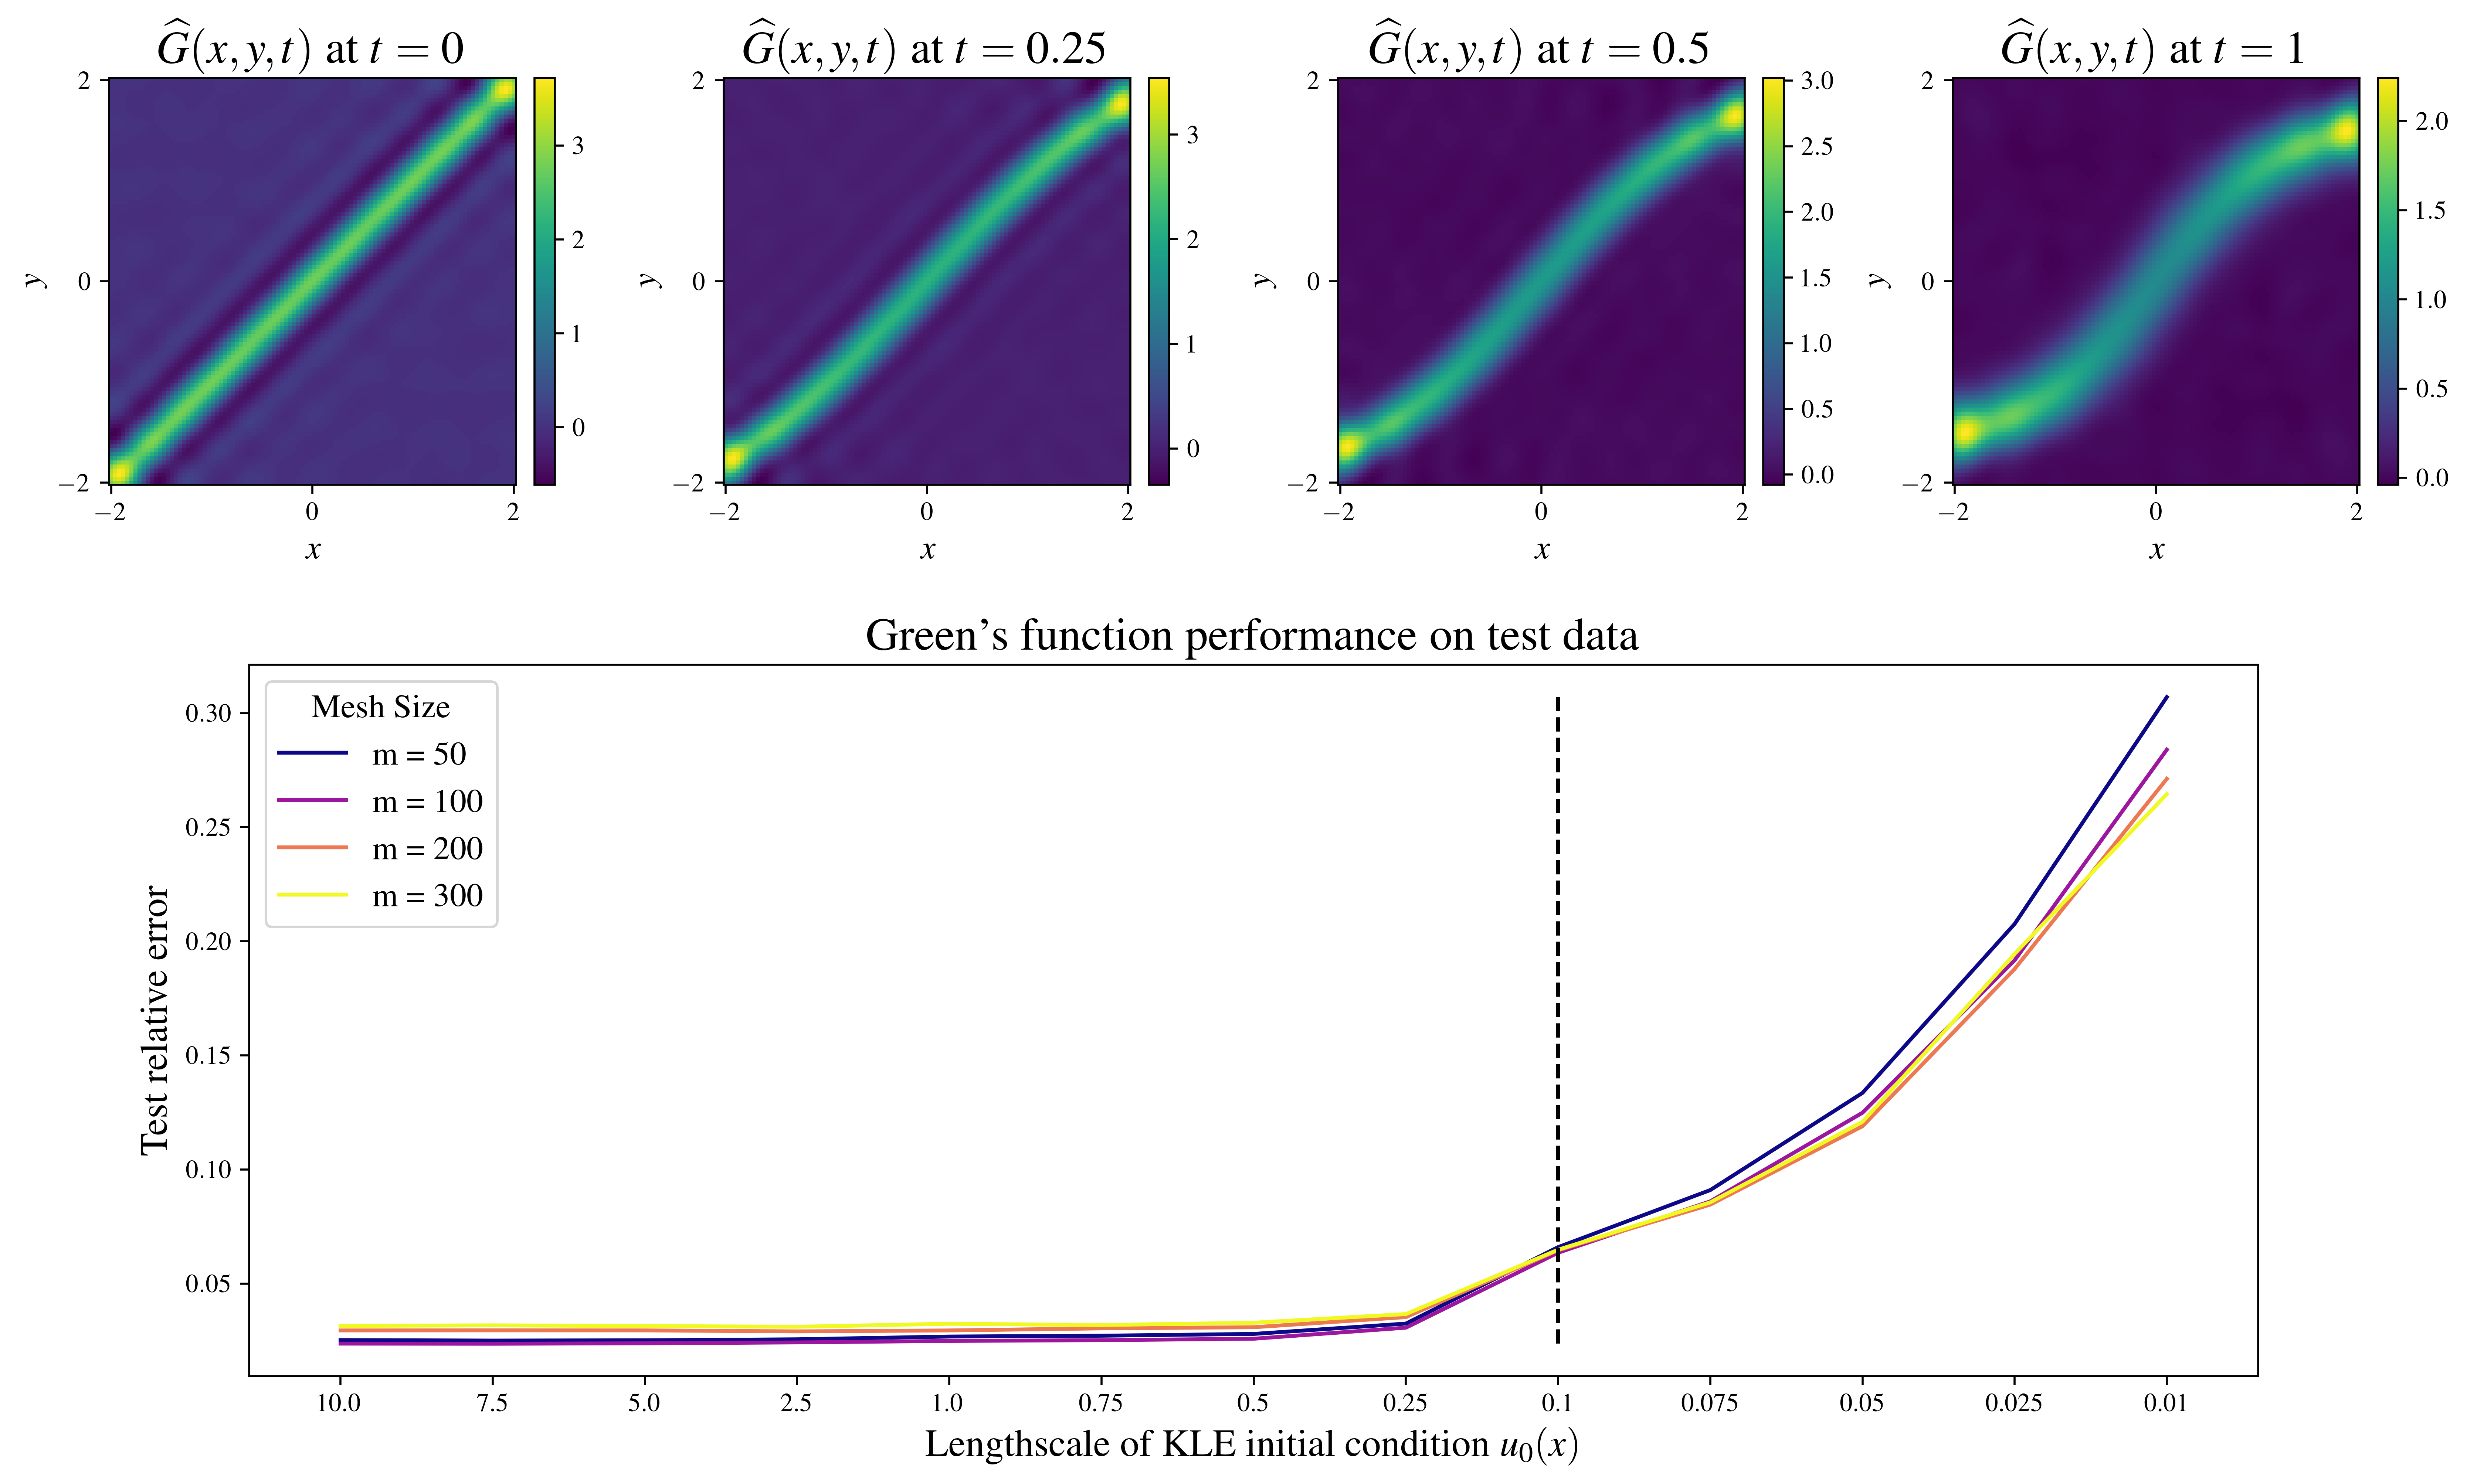

In [17]:
greens_function.update_mesh(greens_out_meshes_true)
G = greens_function()

inds = [0, 25, 50, 99]
ts = ["0", "0.25", "0.5", "1"]

fig = plt.figure(tight_layout=True, figsize=(13, 8), dpi=500)
subfigs = fig.subfigures(2, 1, height_ratios=[1, 1])
axsTop = subfigs[0].subplots(1, len(inds))
axsBottom = subfigs[1].subplots(1, 1)

for i in range(len(inds)):
    im = axsTop[i].pcolormesh(x_true.cpu(), x_true.cpu(), G.cpu().detach().view(mx_true, mx_true, mt_true)[:, :, inds[i]].T)
    axsTop[i].set_aspect(1)
    axsTop[i].set_title(f"$\widehat{{G}}(x, y, t)$ at $t = {ts[i]}$", fontsize=18)
    axsTop[i].set_xlabel('$x$', fontsize=13)
    axsTop[i].set_ylabel('$y$', fontsize=13)
    axsTop[i].set_xticks([-2, 0, 2])
    axsTop[i].set_yticks([-2, 0, 2])
    divider = make_axes_locatable(axsTop[i])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')

axsBottom.set_prop_cycle(plt.cycler('color', plt.cm.plasma(np.linspace(0, 1, len(mesh_sizes)))))
axsBottom.set_aspect(15)
axsBottom.plot(test_mesh_res.T)
axsBottom.vlines(4, np.min(test_mesh_res), np.max(test_mesh_res), color="black", linestyle="dashed")
axsBottom.set_title("Green's function performance on test data", fontsize=18)
axsBottom.set_xticks(np.arange(len(kernel_width_sizes)))
axsBottom.set_xticklabels(kernel_width_sizes)
axsBottom.set_xlabel('Lengthscale of KLE initial condition $u_0(x)$', fontsize=15)
axsBottom.set_ylabel('Test relative error', fontsize=15)
axsBottom.invert_xaxis()
leg = axsBottom.legend([f"m = {m}" for m in mesh_sizes], fontsize = 13)
leg.set_title("Mesh Size", prop={'size':13})

plt.savefig("../../figures/fplanck_test.png", bbox_inches="tight")
plt.show()

/state/partition1/slurm_tmp/20492549.0.0/ipykernel_5373/4179341120.py:125: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("../../figures/fplanck_examples.png", bbox_inches="tight")
/state/partition1/slurm_tmp/20492549.0.0/ipykernel_5373/4179341120.py:125: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("../../figures/fplanck_examples.png", bbox_inches="tight")
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


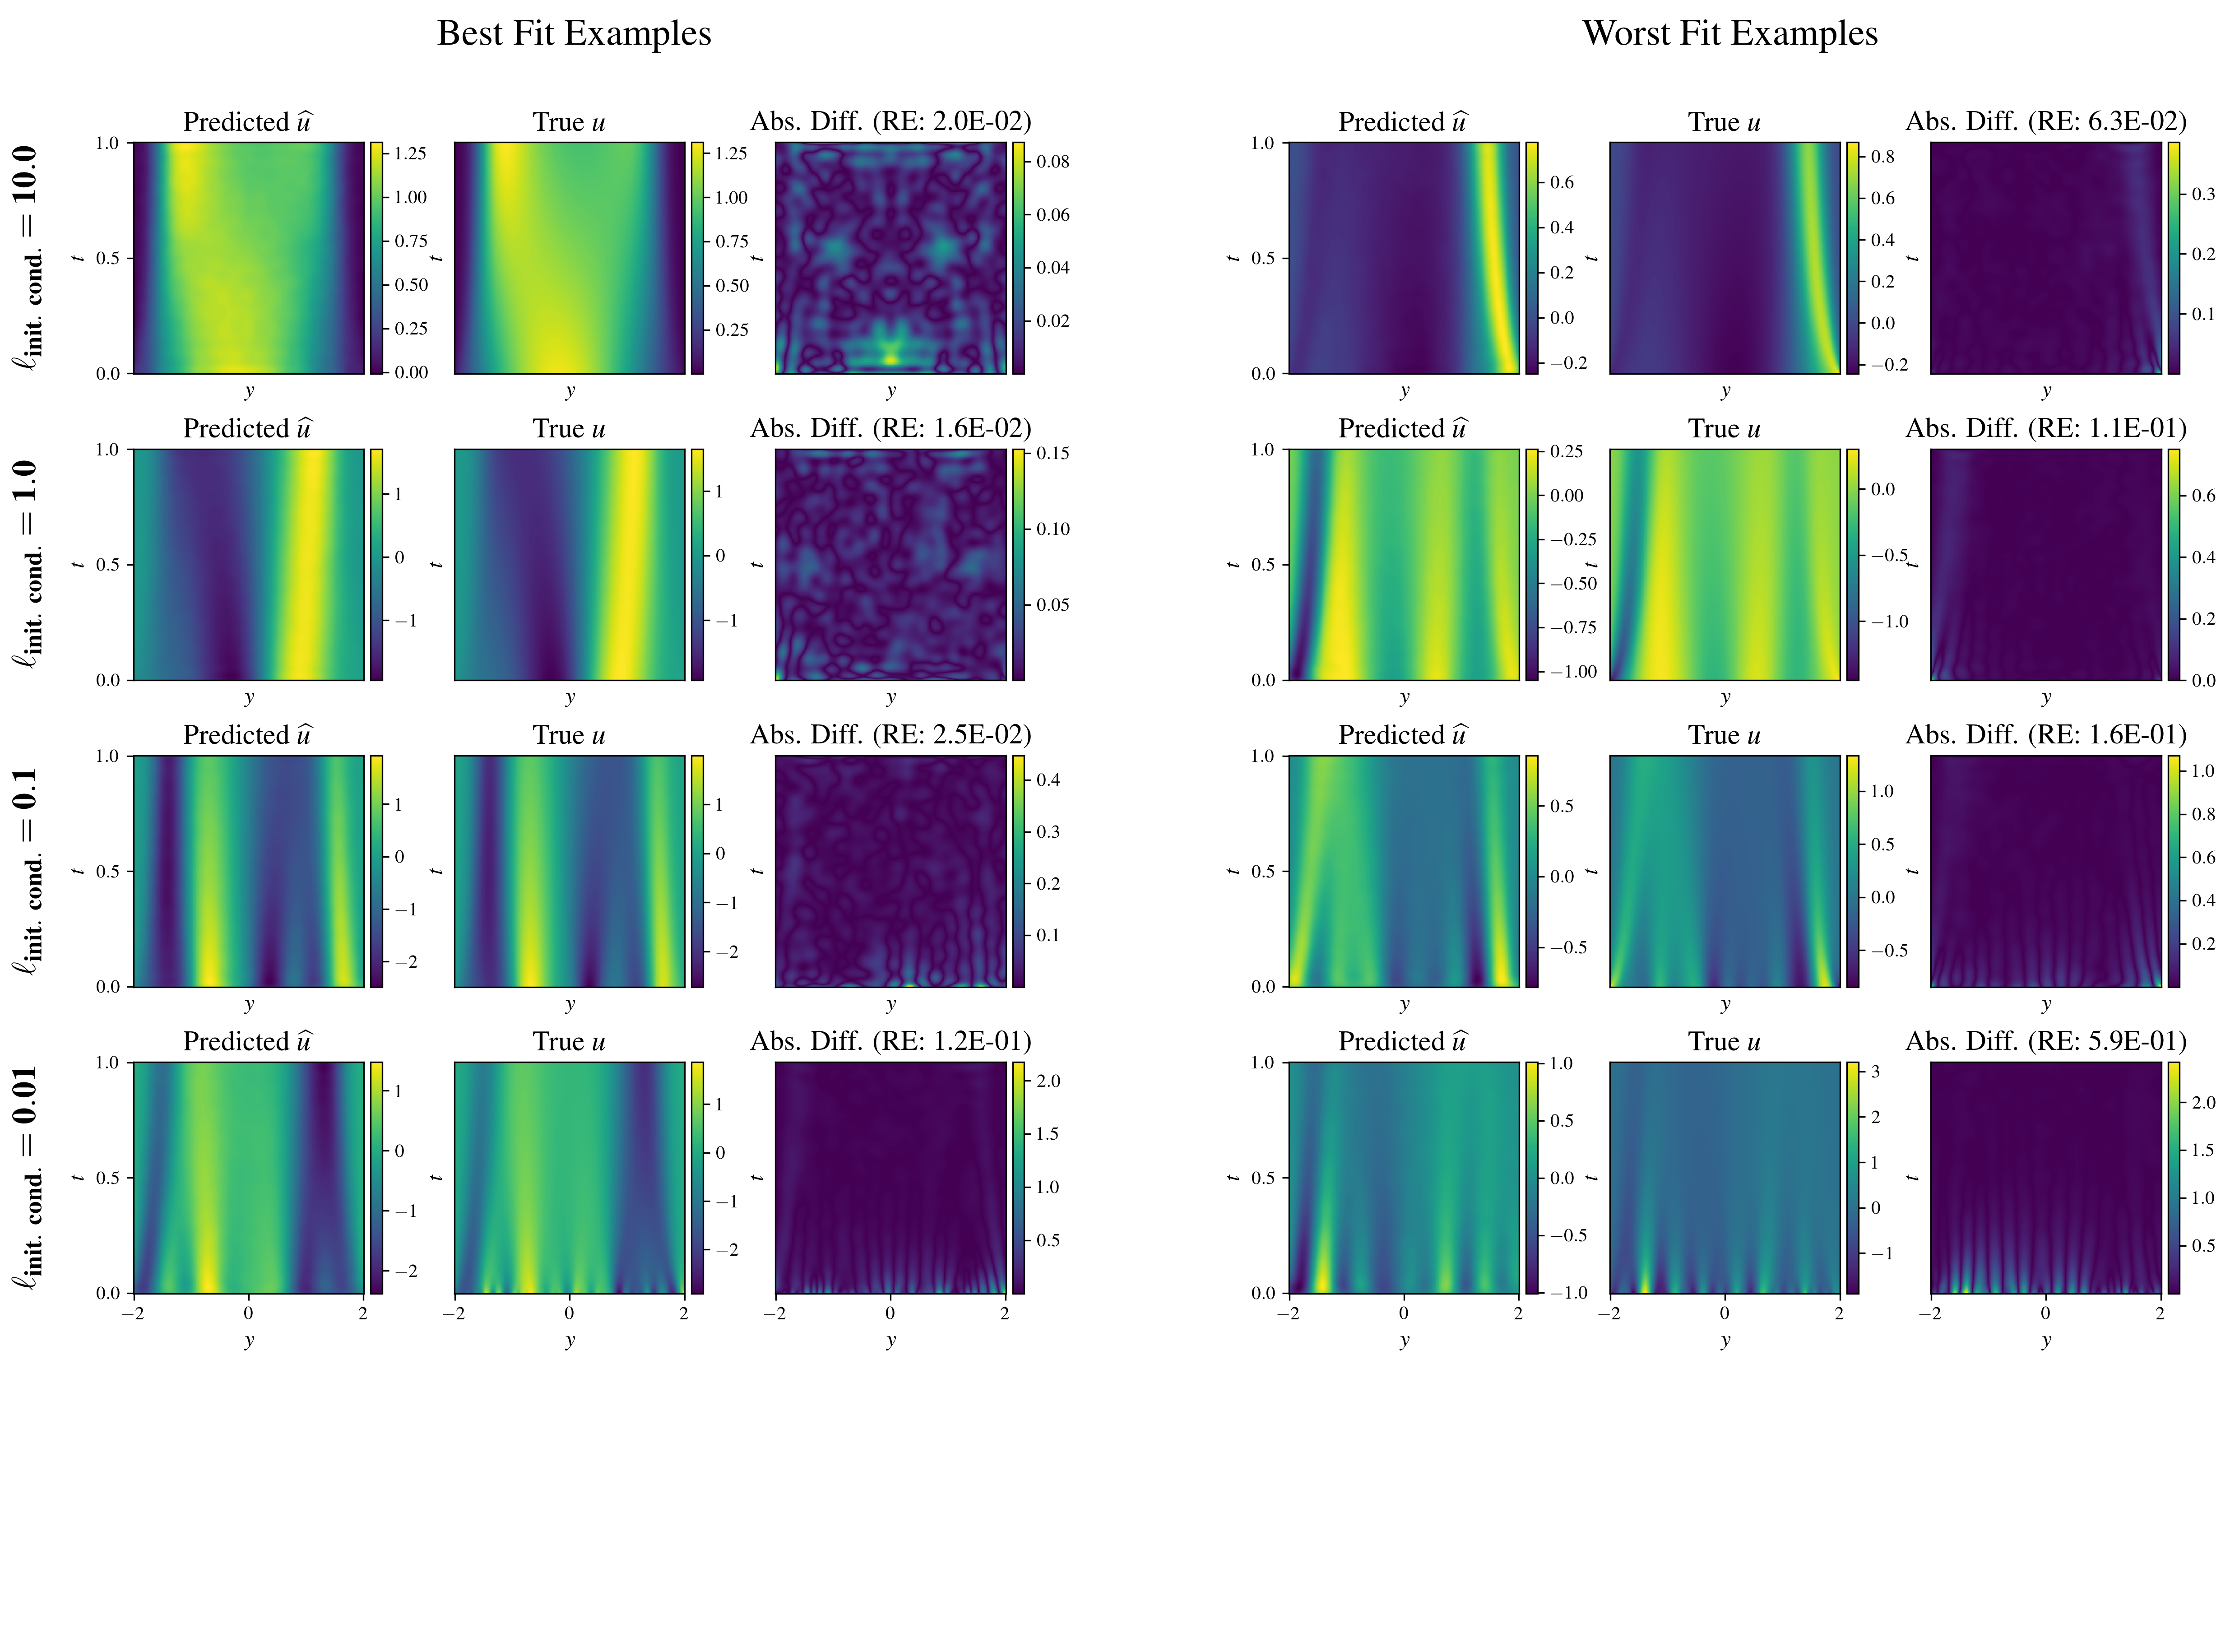

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(16, 12), dpi=300)
subfigs = fig.subfigures(1, 4, width_ratios=[0.05, 1, 0.2, 1])
subfigslabel = subfigs[0].subfigures(6, 1, wspace=1, hspace=1, height_ratios=[0.3, 1, 1, 1, 1, 1])
subfigsleft = subfigs[1].subfigures(6, 1, wspace=1, hspace=1, height_ratios=[0.3, 1, 1, 1, 1, 1])
subfigsright = subfigs[3].subfigures(6, 1, wspace=1, hspace=1, height_ratios=[0.3, 1, 1, 1, 1, 1])

subfigs[1].suptitle("Best Fit Examples", fontsize = 20)
subfigs[3].suptitle("Worst Fit Examples", fontsize = 20)

chosen_kernel_inds = [12, 8, 4, 0]
for i in range(len(chosen_kernel_inds)):
    ax = subfigslabel[i+1].subplots(1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylabel(f"$\mathbf{{\ell_{{init. \ cond.}} = {kernel_width_sizes[chosen_kernel_inds[i]]}}}$", fontsize = 18)
    
    # Best fits
    #subfigsnest[i, 0].set_facecolor('lightgreen')
    subsubfig = subfigsleft[i+1].subfigures(1, 3, width_ratios=[1, 1, 1])
    
    u = best_u[-1, chosen_kernel_inds[i]]
    u_hat = best_u_hat[-1, chosen_kernel_inds[i]]
    
    ax = subsubfig[0].subplots(1, 1)
    im = ax.pcolormesh(x_test.cpu(), t_test.cpu(), u_hat.T)
    #ax.set_aspect(4)
    ax.set_title("Predicted $\widehat{u}$", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks([-2, 0, 2])
    ax.set_yticks([0, 0.5, 1])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax = subsubfig[1].subplots(1, 1)
    im = ax.pcolormesh(x_test.cpu(), t_test.cpu(), u.T)
    #ax.set_aspect(4)
    ax.set_title("True $u$", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks([-2, 0, 2])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax = subsubfig[2].subplots(1, 1)
    im = ax.pcolormesh(x_test.cpu(), t_test.cpu(), torch.abs(u - u_hat).T)
    #ax.set_aspect(4)
    ax.set_title(f"Abs. Diff. (RE: {best_res[-1, chosen_kernel_inds[i]]:.1E})", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks([-2, 0, 2])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    # Worst fits
    #subfigsnest[i, 1].set_facecolor('coral')
    subsubfig = subfigsright[i+1].subfigures(1, 3, width_ratios=[1, 1, 1])
    
    u = worst_u[-1, chosen_kernel_inds[i]]
    u_hat = worst_u_hat[-1, chosen_kernel_inds[i]]
    
    ax = subsubfig[0].subplots(1, 1)
    im = ax.pcolormesh(x_test.cpu(), t_test.cpu(), u_hat.T)
    #ax.set_aspect(4)
    ax.set_title("Predicted $\widehat{u}$", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks([-2, 0, 2])
    ax.set_yticks([0, 0.5, 1])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax = subsubfig[1].subplots(1, 1)
    im = ax.pcolormesh(x_test.cpu(), t_test.cpu(), u.T)
    #ax.set_aspect(4)
    ax.set_title("True $u$", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks([-2, 0, 2])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax = subsubfig[2].subplots(1, 1)
    im = ax.pcolormesh(x_test.cpu(), t_test.cpu(), torch.abs(u - u_hat).T)
    #ax.set_aspect(4)
    ax.set_title(f"Abs. Diff. (RE: {worst_res[-1, chosen_kernel_inds[i]]:.1E})", fontsize = 15)
    ax.set_xlabel('$y$', fontsize = 12)
    ax.set_ylabel('$t$', fontsize = 12)
    if i < len(chosen_kernel_inds)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks([-2, 0, 2])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.savefig("../../figures/fplanck_examples.png", bbox_inches="tight")
plt.show()

In [ ]:
i = 0
m = 150
w = 10.0
fs_test_sample = data[f"mesh{m}"][f"kernelwidth{w}"]["forcings"][i, :]

plt.figure(dpi=100)
plt.plot(x_test.cpu(), fs_test_sample)
plt.xlabel("$x$", fontsize=16)
plt.title("Initial condition $u_0(x)$", fontsize=20)
#plt.savefig("../../figures/fplanck_initialcond.png")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3), dpi=500)

i = -1
j = 0
m = mesh_sizes[i]
w = kernel_width_sizes[j]
print(f"Mesh Size: {m}, Kernel Size: {w}")

x_test, t_test = data[f"mesh{m}"].attrs["mesh"]

f = best_f[i, j]
u = best_u[i, j]
u_hat = best_u_hat[i, j]

axs[0].plot(x_test, f)
axs[0].set_title("Input $u_0(x)$")
axs[0].set_xlabel('$x$')
axs[0].set_xticks([-2, 0, 2])

im = axs[1].pcolormesh(x_test, t_test, u_hat.T)
axs[1].set_title("Predicted $\widehat{u}(y, t)$")
axs[1].set_xlabel('$y$')
axs[1].set_ylabel('$t$')
axs[1].set_xticks([-2, 0, 2])
axs[1].set_yticks([0, 0.5, 1])
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[2].pcolormesh(x_test, t_test, u.T)
axs[2].set_title("True $u(y, t)$")
axs[2].set_xlabel('$y$')
axs[2].set_ylabel('$t$')
axs[2].set_xticks([-2, 0, 2])
axs[2].set_yticks([])
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[3].pcolormesh(x_test, t_test, torch.abs(u - u_hat).T)
axs[3].set_title(f"Abs. Diff. (RE: {best_res[i, j]:.1E})")
axs[3].set_xlabel('$y$')
axs[3].set_ylabel('$t$')
axs[3].set_xticks([-2, 0, 2])
axs[3].set_yticks([])
divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

fig.tight_layout()